In [1]:
!rm -r AI2021BS
!git clone https://github.com/UmbertoJr/AI2021BS.git

rm: cannot remove 'AI2021BS': No such file or directory
Cloning into 'AI2021BS'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 93 (delta 37), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (93/93), done.


## Second Lab

What we are going to do today:
- Recap of the previous Lab
- Define the nearest neighbor method and use it
- Define the Best Nearest Neighbors and use it 
- Define the Multi Fragment and use it
- Define the Clarke-Wright and use it
- Finally compare these Constructive Methods

This cell below is simply importing some useful stuff for later

In [2]:
import glob
import numpy as np
from matplotlib import pyplot as plt

from time import time as t

## Recap
### The problems
As we saw last time, we have 12 problems and two have an optimal solution

In [3]:
problems = glob.glob('AI2021BS/problems/*.tsp')
for prob in problems:
    if prob in ["AI2021BS/problems/eil76.tsp", "AI2021BS/problems/kroA100.tsp"]:
        print(f"- {prob[18:]} with opt", sep='\t')
    else:
        print(f"- {prob[18:]}", sep='\t')

- kroA100.tsp with opt
- lin318.tsp
- pr439.tsp
- ch130.tsp
- d198.tsp
- u1060.tsp
- eil76.tsp with opt
- rat783.tsp
- pcb442.tsp
- fl1577.tsp


#### ProblemInstance Class
Last time we implemented an ProblemInstance class that we can use to load a problem. 

In [4]:
from AI2021BS.src.io_tsp import ProblemInstance



#############################
name: eil76
nPoints: 76
best_sol: 538.0
exist optimal: True


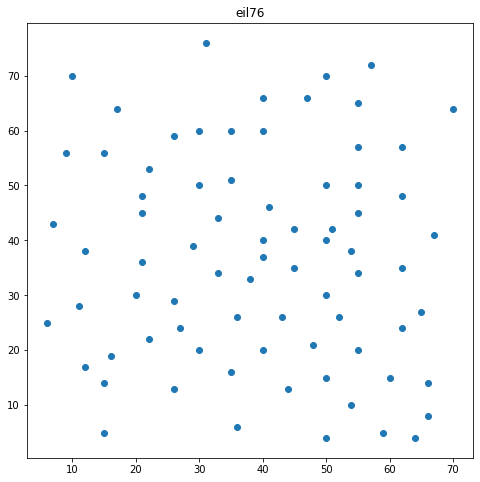

[[ 0. 15. 23. ... 18. 23. 25.]
 [15.  0. 24. ...  7. 12. 15.]
 [23. 24.  0. ... 31. 21. 20.]
 ...
 [18.  7. 31. ...  0. 17. 20.]
 [23. 12. 21. ... 17.  0.  3.]
 [25. 15. 20. ... 20.  3.  0.]]


In [5]:
example_problem = "AI2021BS/problems/eil76.tsp"
p_inst = ProblemInstance(example_problem)
p_inst.print_info()
p_inst.plot_data()
print(p_inst.dist_matrix)

### TSPSolver Class
Even here, instead of reimplementing the class everytime, we can import the one I prepared before.
This implementation is ready to receive a lot of different types of problems

In [6]:
from AI2021BS.src.TSP_solver import TSPSolver
from AI2021BS.src.constructive_algorithms import random_method

The class implements the following methods:
...

###  solving with ['random'] ####


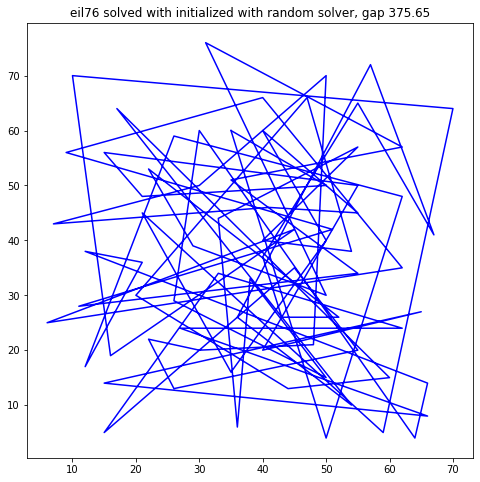

best solution with len 2559.0 
with a total time of 0.00169 seconds


In [7]:
available_solvers = {"random": random_method}

solver = TSPSolver("random", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Let's analyse the performances of the random Method


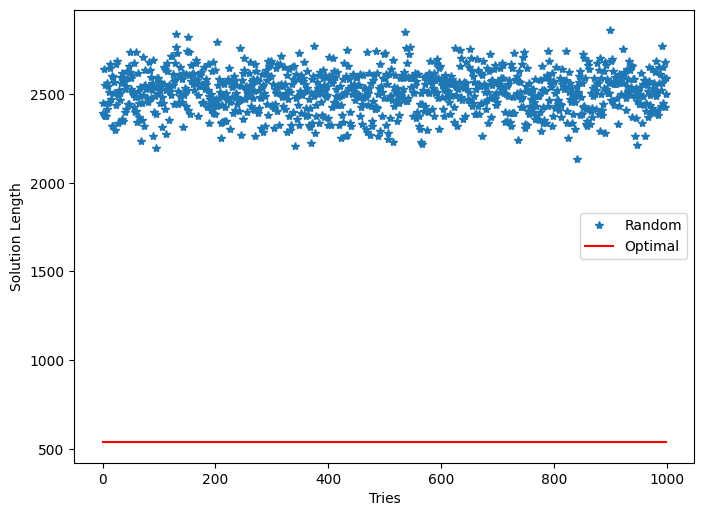

best solution 2136.0 on 1000 trials,
with a total time of 0.8 seconds


In [8]:
number_of_trials = 1000
found_lens = []
start = t()
for _ in range(number_of_trials):
    solver.compute_solution(return_value=False, verbose=False)
    found_lens.append(solver.found_length)
end = t()
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.ylabel("Solution Length")
plt.xlabel("Tries")
plt.plot(found_lens, "*",label="Random")
plt.plot(np.ones(number_of_trials)*p_inst.best_sol, "r-",label="Optimal")
plt.legend(loc="center right")
plt.show()

print(f"best solution {min(found_lens)} on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

-------------
## Constructive Algorithm
### Nearest Neighbor Method

In [9]:
def nn( instance_, starting_node=0): 
    dist_matrix = np.copy(instance_.dist_matrix)
    n = int(instance_.nPoints)
    node = starting_node
    tour = [node]
    # Suggestion ^^^^
    for _ in range(n - 1):
        for new_node in np.argsort(dist_matrix[node]):
              if new_node not in tour:
                    tour.append(new_node)
                    node = new_node
                    break
    return np.array(tour)

###  solving with ['nn'] ####


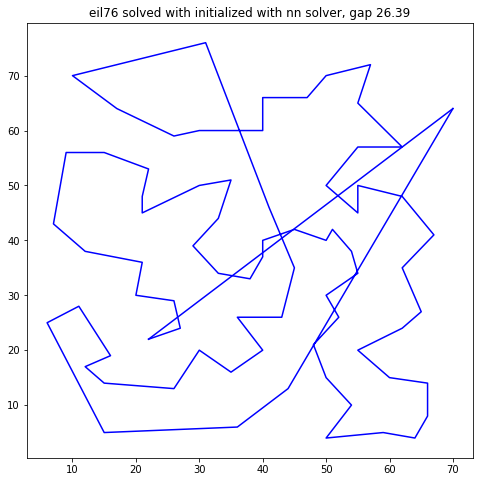

best solution with len 680.0 
with a total time of 0.00607 seconds


In [10]:
available_solvers = {"random": random_method,
                     "nn":nn}

solver = TSPSolver("nn", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Best Nearest Neighbors

In [11]:
def best_nn(instance):
    solutions, lens = [], []
    for starting_node in range(instance.nPoints):
        new_solution = nn(instance, starting_node=starting_node)
        solutions.append(new_solution)
        solver.solution = new_solution
        lens.append(solver.evaluate_solution(return_value=True))
    solution = solutions[np.argmin(lens)]
    return solution 

###  solving with ['best_nn'] ####


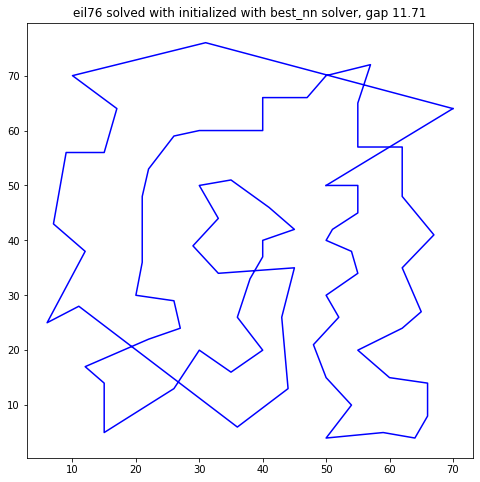

best solution with len 601.0 
with a total time of 0.07076 seconds


In [12]:
available_solvers = {"random": random_method,
                     "nn": nn,
                     "best_nn":best_nn}

solver = TSPSolver("best_nn", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Multi Fragment

In [16]:
def check_if_available(n1, n2, sol):
    return (len(sol[str(n1)]) < 2) and (len(sol[str(n2)]) < 2)

def check_if_not_close(edge_to_append, sol):
    n1, n2 = edge_to_append
    # from_city = n2
    if len(sol[str(n1)]) == 0:
      return True
    if len(sol[str(n2)]) == 0:
      return True
    cur_city = sol[str(n1)][0]
    partial_tour = [n1, cur_city]
    while True:
      if len(sol[str(cur_city)]) == 2:
        for i in sol[str(cur_city)]:
          if i not in partial_tour:
            cur_city = i
            partial_tour.append(cur_city)
            if cur_city == n2:
              return False
      else:
        if cur_city == n2:
          return False
        else:
          return True

def create_solution(start_sol, sol, n):
    assert len(start_sol) == 2, "too many cities with just one link"
    end = False
    n1, n2 = start_sol
    from_city = n2
    sol_list = [n1, n2]
    while not end:
        for node_connected in sol[str(from_city)]:
            # print(node_connected, from_city)
            # print(sol_list)
            # print(sol)
            if node_connected not in sol_list:
                from_city = node_connected
                sol_list.append(node_connected)
            if len(sol_list) == n:
                end = True
    return sol_list

def mf(instance):
  mat = np.copy(instance.dist_matrix)
  mat = np.triu(mat)
  mat[mat == 0] = 100000
  num_cit = instance.dist_matrix.shape[0]
  start_list = [i for i in range(num_cit)]
  solution = {str(i): [] for i in range(num_cit)}
  inside = 0
  for el in np.argsort(mat.flatten()):
      node1, node2 = el // num_cit, el % num_cit
      possible_edge = [node1, node2]

      if check_if_available(node1, node2,solution):
          if check_if_not_close(possible_edge, solution):
              solution[str(node1)].append(node2)
              solution[str(node2)].append(node1)
              if len(solution[str(node1)]) == 2:
                  start_list.remove(node1)
              if len(solution[str(node2)]) == 2:
                  start_list.remove(node2)
              inside += 1
              if inside == num_cit - 1:
                  solution = create_solution(start_list, solution, num_cit)
                  return solution



###  solving with ['multi_fragment'] ####


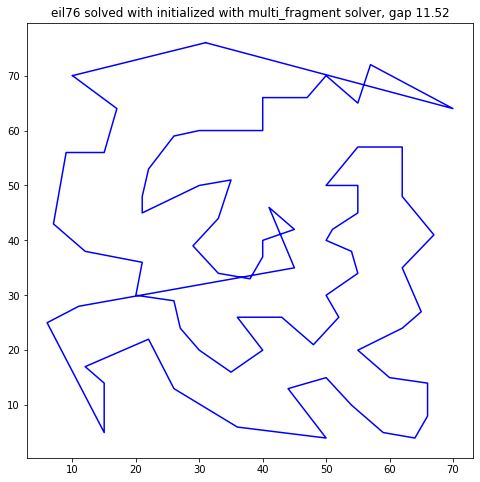

best solution with len 600.0 
with a total time of 0.0069 seconds


In [17]:
available_solvers = {"random": random_method,
                     "nn":nn,
                     "best_nn":best_nn,
                     "multi_fragment": mf
                    }

solver = TSPSolver("multi_fragment", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Clarke-Wright 



In [18]:
def remove_hub(solution, hub_node):
    list_to_rem = solution[str(hub_node)]
    for node in list_to_rem:
        solution[str(node)].remove(hub_node)
    solution[str(hub_node)] = []
    return solution, len(list_to_rem)

def get_free_nodes(solution):
    free = []
    for key in solution.keys():
        if len(solution[key]) < 2:
            free.append(int(key))
    return free

def find_hub(dist_matrix):
    return np.argmin(np.sum(dist_matrix, axis=0))

def compute_savings(dist_matrix, hub_node):
    n = dist_matrix.shape[0]
    A = np.tile(dist_matrix[hub_node], n).reshape((n, n))
    return A + np.transpose(A) - dist_matrix

def cw(instance):
  inside = 0
  dist_matrix = instance.dist_matrix
  hub_node = find_hub(dist_matrix)
  savings_mat = compute_savings(dist_matrix, hub_node)
  mat = np.triu(savings_mat, 1)
  num_cit = mat.shape[0]
  start_list = [i for i in range(num_cit)]
  solution = {str(i): [] for i in range(num_cit)}
  for el in np.argsort(mat.flatten())[::-1]:
      node1, node2 = el // num_cit, el % num_cit
      possible_edge = [node1, node2]
      if hub_node not in possible_edge:
          if check_if_available(node1, node2, solution):
              if check_if_not_close(possible_edge, solution):
                  solution[str(node1)].append(node2)
                  solution[str(node2)].append(node1)
                  if len(solution[str(node1)]) == 2:
                      start_list.remove(node1)
                  if len(solution[str(node2)]) == 2:
                      start_list.remove(node2)
                  inside += 1
                  if inside == num_cit - 2:
                      free_list = get_free_nodes(solution)
                      if hub_node in free_list:
                          free_list.remove(hub_node)
                      node1 = free_list[0]
                      node2 = free_list[1]
                      solution[str(hub_node)] = [node1]
                      solution[str(node1)].append(hub_node)
                      start_list.remove(node1)
                      solution_list = create_solution(start_list, solution, num_cit)
                      return solution_list

###  solving with ['clarke wright'] ####


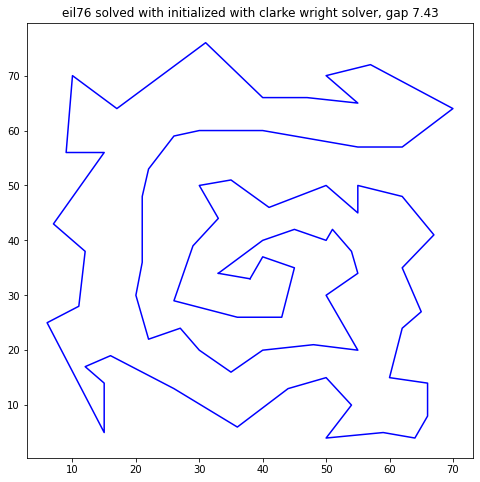

best solution with len 578.0 
with a total time of 0.01336 seconds


In [19]:
available_solvers = {"random": random_method,
                     "nn":nn,
                     "best_nn":best_nn,
                     "multi_fragment": mf,
                     "clarke wright": cw
                    }

solver = TSPSolver("clarke wright", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Comparison Constructive methods

In [20]:
from time import time as t
import pandas as pd
from tqdm import tqdm

available_solvers = {"random": random_method,
                     "nn":nn,
                     "best_nn":best_nn,
                     "multi_fragment": mf,
                     "clarke wright" : cw
                    }

show_plots = False
verbose = False
problems = ["AI2021BS/problems/eil76.tsp", "AI2021BS/problems/kroA100.tsp", 
            "AI2021BS/problems/ch130.tsp", "AI2021BS/problems/d198.tsp"]
methods = available_solvers.keys()
results = []
index = []
with tqdm(problems) as tq:
    for filename in tq:
        p_inst = ProblemInstance(filename)
        if verbose:
            print("\n\n#############################")
            p_inst.print_info()
        if show_plots:
            p_inst.plot_data()

        for method in methods:
            tq.set_postfix_str(f"using {method} for {p_inst.name}")
            solver = TSPSolver(method, p_inst, available_solvers)
            start = t()
            solver.compute_solution(return_value=False, verbose=verbose)
            end = t()
            if verbose:   
                print(f"the total length for the solution found is {solver.found_length}",
                        f"while the optimal length is {p_inst.best_sol}",
                        f"the gap is {solver.gap} %",
                        f"the solution is found in {np.round(end - start, 5)} seconds",sep="\n")
            index.append((filename[18:], method))
            results.append([solver.found_length, p_inst.best_sol, solver.gap, end - start])

            if show_plots:
                  solver.plot_solution()

            if p_inst.exist_opt and show_plots:
                solver = TSPSolver("optimal", p_inst)
                solver.solved = True
                solver.solution = np.concatenate([p_inst.optimal_tour, [p_inst.optimal_tour[0]]])
                solver.plot_solution()


100%|██████████| 4/4 [00:02<00:00,  1.95it/s, using clarke wright for d198]


In [21]:
index = pd.MultiIndex.from_tuples(index, names=['problem', 'method'])

df = pd.DataFrame(results, index=index, columns=["tour length", "optimal solution", "gap", "time to solve"])
df

tour length  ...  time to solve
problem     method                       ...               
eil76.tsp   random               2773.0  ...       0.000978
            nn                    680.0  ...       0.003366
            best_nn               601.0  ...       0.076214
            multi_fragment        600.0  ...       0.008512
            clarke wright         578.0  ...       0.012115
kroA100.tsp random             168968.0  ...       0.001138
            nn                  27807.0  ...       0.003612
            best_nn             24815.0  ...       0.153570
            multi_fragment      24287.0  ...       0.010639
            clarke wright       22568.0  ...       0.012401
ch130.tsp   random              44190.0  ...       0.001545
            nn                   7578.0  ...       0.007108
            best_nn              6880.0  ...       0.314189
            multi_fragment       7849.0  ...       0.024797
            clarke wright        6567.0  ...       0.025923
d198.tsp    random             191113.0  ...       0.003918
            nn                  18975.0  ...       0.008360
            best_nn             17565.0  ...       0.985613
            multi_fragment      19016.0  ...       0.047110
            clarke wright       16639.0  ...       0.046086

[20 rows x 4 columns]